In [4]:
from typing import Tuple
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader

In [5]:
import os, sys
sys.path.append(os.path.abspath('..'))

from src.models.unet import UNet
from src.training.metrics import dice_loss
from src.training.metrics import evaluate

In [6]:
from src.data.datasets import ACDCDataset

dataset = torch.load('../checkpoints/acdc_dataset.pt')

In [6]:
train_set, val_set = random_split(dataset, [950, 2], generator=torch.Generator().manual_seed(42))
loader_train = DataLoader(train_set, batch_size=8, shuffle=True)
loader_val = DataLoader(val_set, batch_size=202, shuffle=False)

In [7]:
model = UNet(n_channels=1, n_classes=4, bilinear=True).double()

In [12]:
optimizer = optim.RMSprop(model.parameters(), lr=1e-3, weight_decay=1e-4, momentum=.9)
criterion = nn.CrossEntropyLoss()

progress = tqdm(range(5), leave=False)

for epoch in progress:
        
    epoch_loss = 0.
    
    model.train()
    
    # Extracts tensors of size (Batch, 1, Width, Height)
    for inp, target in tqdm(loader_train, leave=False):
        optimizer.zero_grad()
        target = target.long()
        
        out = model(inp)
        loss = criterion(out, target) + dice_loss(out, target)
                    
        loss.backward()
        optimizer.step()
                
        epoch_loss += loss.item()
    
    val_score = evaluate(model, loader_val)
    
    progress.set_description(f'Epoch {epoch:<3} | Loss {epoch_loss:,.5f} | Val {val_score:,.3f}')
    

torch.save(model, '../checkpoints/unet_acdc_5_epochs.pt')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

In [29]:
image.count_nonzero()

tensor(131072)

In [8]:
evaluate(model, loader_val)

  0%|          | 0/1 [00:00<?, ?batch/s][W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


tensor(0.0070)

In [28]:
image, target = next(iter(loader_val))
image.shape, image.dtype, target.shape, target.dtype

(torch.Size([2, 1, 256, 256]),
 torch.float64,
 torch.Size([2, 256, 256]),
 torch.float32)

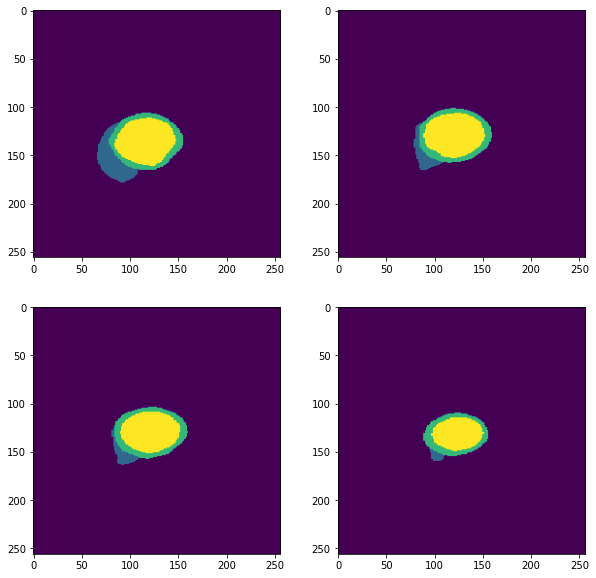

In [13]:
target1, target2 = dataset[12][1], dataset[14][1]
target3, target4 = dataset[15][1], dataset[17][1]

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(target1), ax[0, 1].imshow(target2)
ax[1, 0].imshow(target3), ax[1, 1].imshow(target4)

plt.show()

In [15]:
from src.training.metrics import dc

In [21]:
sum([dc(target1, target2), dc(target3, target4)]) / 2

tensor(0.8160)

In [19]:
dc(
    torch.cat([target1.unsqueeze(0), target3.unsqueeze(0)], dim=0),
    torch.cat([target2.unsqueeze(0), target4.unsqueeze(0)], dim=0)
)


tensor(0.8147)

In [10]:
output = model(image)
output.shape, output.dtype

(torch.Size([2, 4, 256, 256]), torch.float64)

In [18]:
F.one_hot(output.argmax(dim=1), model.n_classes).permute(0, 3, 1, 2).bool().shape

torch.Size([2, 4, 256, 256])

In [18]:
oh_target = F.one_hot(target.long(), model.n_classes).permute(0, 3, 1, 2)
oh_target.shape

torch.Size([2, 4, 256, 256])

## Brain MRI U-NET

In [ ]:
from brainet.unet import UNet

brainet = UNet()
brainet.load_state_dict(torch.load('../checkpoints/brainet-e012d006.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
with torch.no_grad():
    output = brainet(inp)

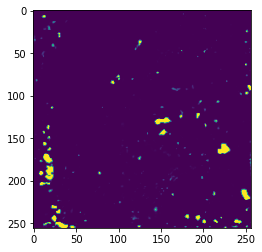

In [ ]:
plt.imshow(output[0, 0])

## Eval

In [ ]:
example, label = next(iter(loader_val))
out = model(example)

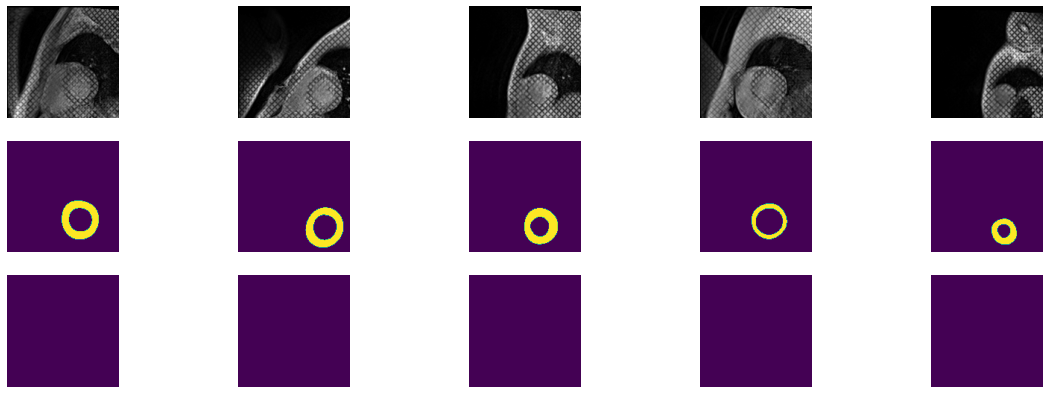

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(20, 7))

for i in range(0, 5):
    ax[0, i % 5].imshow(example[i, 0], cmap='gray')
    ax[1, i % 5].imshow(label[i, 0], alpha=1)
    ax[2, i % 5].imshow(F.softmax(out, dim=1).detach().numpy()[i, 0], alpha=1.)
    ax[0, i % 5].axis('off'), ax[1, i % 5].axis('off'), ax[2, i % 5].axis('off')

In [21]:
example, mask = dataset[1]
output = model(example.unsqueeze(0))

In [22]:
example.shape, mask.shape, output.shape

(torch.Size([1, 256, 256]),
 torch.Size([256, 256]),
 torch.Size([1, 4, 256, 256]))

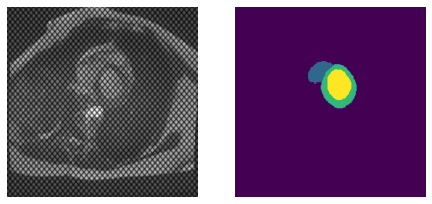

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(7.5, 5))

ax[0].imshow(example[0, ...], cmap='gray'), ax[0].axis('off')
ax[1].imshow(mask[...]), ax[1].axis('off')

plt.show()

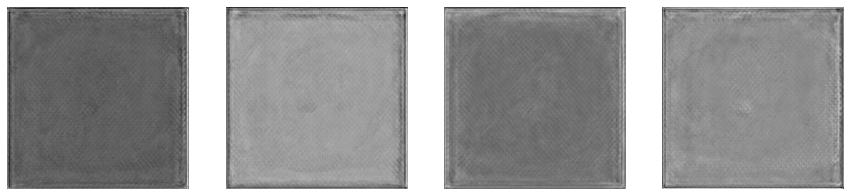

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    ax[i].imshow(output[0, i, ...].detach().numpy(), cmap='gray'), ax[i].axis('off')

plt.show()